<a href="https://colab.research.google.com/github/EmilyBarot/Code101/blob/master/Manufacting_Intelligence_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Manufacturing Intelligence: Case**





## The Data
A gripper grips a component and places it into the assembly in a one dimensional motion. This process sometimes fails. The simulated modes of operation are:
1.   Normal Operation
2.   Slow opening of the grippers
3. The motor has too high velocity
4. The motor applies too much force when placing the component
5. The component was rotated by 90 degrees before assembly

The simulated data consists of 2271 runs, each with 512 observations which include time, demand current and measured position of the gripper. The mode of operation for each run is recorded.






# Step 0: Setup / Configuration

In [0]:
## Connect and authenticate to google drive.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, recall_score, precision_score
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils


# **Step 1: Data Exploration**

It always helps to get to know the data before deciding how to tackle the problem being posed. This section are just some of the data exploration I performed at the beginning of this task. 

In [0]:
## read the data and preview it - get to know the structure and set up
df = pd.read_csv("/content/gdrive/My Drive/Data_Scientist_Interview/runs_data.csv")
df.head()

,Unnamed: 0,time,measured_position,demand_current,operation_mode,run_no
0,0,0.000,-0.0003,-1.848,1,0
1,1,0.006,0.0018,-1.876,1,0
2,2,0.012,-0.0003,-1.836,1,0
3,3,0.018,0.0003,-1.852,1,0
4,4,0.024,-0.0009,-1.841,1,0


Moving on from simple inspection of columns, blox plots illustrate any difference in distributions between the operation modes. As this is a large data set (with 512 observations per run), the following boxplots were made using only a sample of the data.

In [164]:
## sample the data as 1000 per class sufficient and quicker.
sampled_df = df.groupby('operation_mode', as_index=False).apply(pd.DataFrame.sample, n=1000, replace=False).reset_index()

## boxplot of demand current
box_d = alt.Chart(sampled_df).mark_boxplot().encode(y='operation_mode:N',
                                                    x='demand_current:Q', 
                                                    color = 'operation_mode:N')

## boxplot of measure position
box_m = alt.Chart(sampled_df).mark_boxplot().encode(y='operation_mode:N',
                                                    x='measured_position:Q', 
                                                    color = 'operation_mode:N')
box_d & box_m

alt.VConcatChart(...)

**Findings:**
* Operation mode 5, where the component is rotated, is noticably different from all other operation modes.
  * It generally requires a greater current and is at a further position.
* There are also outliers in operation modes 3 and 4 for the current
  * This is somewhat expected as these are the mode where the motor has too high velocity and applies too much force, respectively.
* Operation modes 1 and 2 are very similar with respect to the demand current boxplots, and modes 1,2,3 and 4 are similar when considering the measured position.

I was curious to see if a greater difference between the mode of operation, could be seen when looking at the overage position or current as function of time. 

In [167]:
## line chart of measure position and demand current over time
interval = alt.selection_single()
base_chart = alt.Chart(sampled_df).mark_line(opacity=0.8).encode(
    x='time',
    color= alt.condition(interval,'operation_mode:N', alt.value('lightgrey')),
    tooltip='operation_mode').properties(selection = interval) 

scatter = base_chart.encode(y='mean(measured_position)') | base_chart.encode(y='mean(demand_current)')
scatter


alt.HConcatChart(...)

**Findings:**
* Like in the boxplots, modes 1 to 4 have similar measured positions over time
* Modes 3 and 5 behave differently over time with respect to current
* In both plots mode 5 does not return to a base level like the other modes, instead it plateaus at its peak and remains there for the rest of the run.

**Data Exploration Conclusions:**
* Operation mode 5 is noticably different from other modes, with respect to both variables
* There is more variation in the demand current than the measured position, across the 5 operation modes

#**Step 2: Building Classifiers**

ML classifications are often improved through feature engineering. For example reducing your data to key variables about its distribution such as percentiles or means and standard deviations. Furthermore, a reduction of variables reduces the likelihood of the 'curse of dimensionality' occuring. Therefore, for each run percentiles (0.05, 0.25, 0.5, 0.75 and 0.95) where calculated to represent it's distribution. This reduced the number of observations per run from 1024 to 10.



In [0]:
# Grouping the data into runs & looking at the quantiles instead of each observation
quantiles = df.groupby(by=['run_no'], squeeze=True).quantile(q=[.05, .25, .5, .75, .95])
df_quantiles = quantiles.unstack(level=1)
df_quantiles.head()

Unnamed: 0                         ... operation_mode               
             0.05    0.25   0.50    0.75  ...           0.25 0.50 0.75 0.95
run_no                                    ...                              
0           25.55  127.75  255.5  383.25  ...            1.0  1.0  1.0  1.0
1           25.55  127.75  255.5  383.25  ...            1.0  1.0  1.0  1.0
2           25.55  127.75  255.5  383.25  ...            1.0  1.0  1.0  1.0
3           25.55  127.75  255.5  383.25  ...            1.0  1.0  1.0  1.0
4           25.55  127.75  255.5  383.25  ...            1.0  1.0  1.0  1.0

[5 rows x 25 columns]

##**Random Forest**

* Simple implementaiton and robust results
* Model itself is explicit i.e. each tree in the forest can be visualised if desired
* Shed a light on which variables are contributing most to the model - allowing further dimensionality reduction and understanding of the data
* Evaluated using 5-fold cross validation

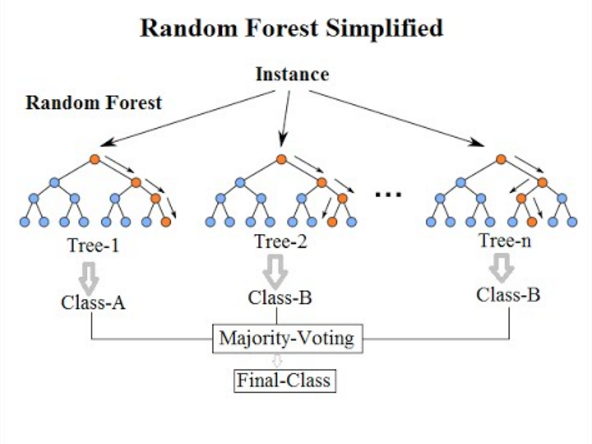

Begin by splitting the data into training and test sets.

In [0]:
def split_samples(df, split_size=0.2):
    """ Compiles the dataframe into x,y, then splits into training and test"""
    df = df.dropna()
    # split into X,y,groups.
    X = df.drop(['operation_mode', 'Unnamed: 0', 'time'], axis=1).values
    Y = np.unique(df['operation_mode'].values, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= split_size, random_state= 0, shuffle=True)
    return x_train, x_test, y_train, y_test

# Split the data into training and test
x_train, x_test, y_train, y_test  = split_samples(df_quantiles)  


Then compile the forest, using 100 trees with a depth of 10 to reduce over-fitting.\
 Each operation mode was weighted based on its abundance in the data set (this simulated set is roughly equal but not completely), so that the model doesn't favour the majority (or easiest) class label. \
The training accuracy was calculated using 5-fold cross validation.

In [179]:
# Build the Random Forest
cv = StratifiedKFold(n_splits=5, shuffle= True)
## important to set the class_weight as balanced for imbalanced datasets.
model = RandomForestClassifier(n_estimators=100, n_jobs= -1, max_depth= 10, min_samples_leaf=50, class_weight = 'balanced')

# 5-fold results scored according to f1 metric.
results = cross_val_score(model, x_train, y_train.ravel(), cv=cv, scoring='f1_weighted')
print("5fold Training Accuracies:", results)

# Fit the model on training data
rf = model.fit(x_train, y_train.ravel())
print("Model Training Accuracy:", model.score(x_test, y_test))


5fold Training Accuracies: [0.950709   0.92813372 0.97518305 0.95593783 0.93384333]
Model Training Accuracy: 0.9560439560439561


The test accuracy of the random forest was evaulated using a confusion matrix and a classification report. Both show that the model is performing well, and each class performs consistently highly. 

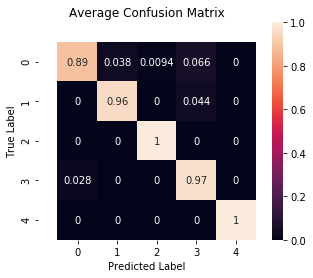

                   precision    recall  f1-score   support

Correct Operation       0.97      0.89      0.93       106
    Slow Grippers       0.96      0.96      0.96       114
    High Velocity       0.98      1.00      0.99        56
       High Force       0.90      0.97      0.93       108
Rotated Component       1.00      1.00      1.00        71

         accuracy                           0.96       455
        macro avg       0.96      0.96      0.96       455
     weighted avg       0.96      0.96      0.96       455

Model Test Accuracy: 0.9560439560439561


In [180]:
# Score the model on test data and create confusion matrix
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = sns.heatmap(cm, vmin=0, vmax=1, annot=True, square=True)
plt.xlim(-0.5, 5)
plt.ylim(5, -0.5)
plt.xlabel('Predicted Label')
plt.ylabel("True Label")
plt.title('Average Confusion Matrix')
plt.show()

# Make the full classification report
class_labels = np.unique(y_test)
class_names = ['Correct Operation','Slow Grippers','High Velocity','High Force','Rotated Component']
print(classification_report(y_test, y_pred, target_names=class_names))

print("Model Test Accuracy:", accuracy_score(y_test, y_pred.round()))

Plotting the variable importance allows us to see what is most important/influential to the model. This goes some way to explain what is happening, and how the model is performing. This can also be useful information when trying to do feature engineering, e.g. dimensionality reduction.



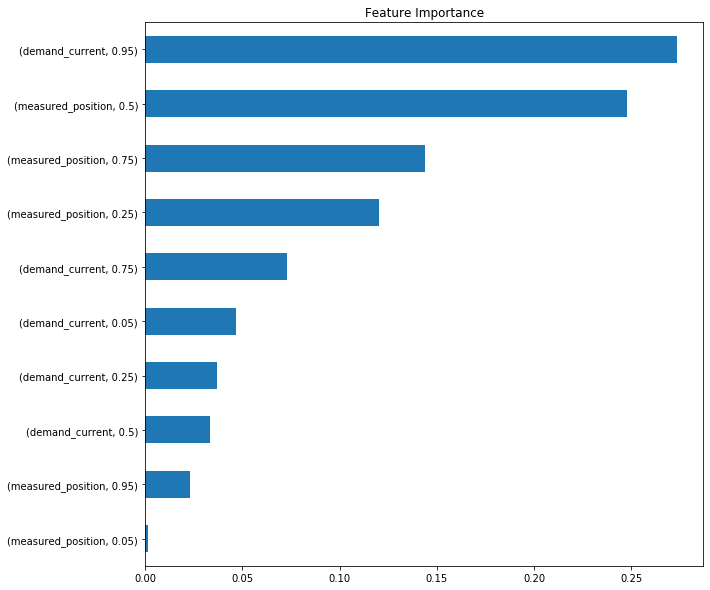

In [171]:
# Variable importance
index = df_quantiles.drop(['operation_mode', 'Unnamed: 0', 'time'], axis=1).columns
feat_importances = pd.Series(rf.feature_importances_, index=index).sort_values()
feat_importances.plot(kind='barh', figsize=(10,10))
plt.title('Feature Importance')
plt.show()


**Findings:**
* Interesting that extreme high current (i.e. at 0.95 quantile) is the most important feature.
* Also interesting that the 'normal bounds' of the measured position ie 0.25, 0.5 and 0.75 quantiles also have a large influence over the model, yet extremes of measured position have the lowest influence.

**Random Forest Summary:**
* Model performs well, with each class performing highly.
* Feature Importance reveals that extremes in current demanded and 'normal bounds' of measure position have the greatest influence over the model itself. 

## **Neural Network**

By building a neural network as well, the outcomes of the random forest classifier can be compared and evaluated. \
Neural networks require more pre-processing (e.g. normalisation) and a great consideration of the model architecture itself. The network here is fully-connected with 2 hidden layers and a single dropout layer to help prevent over-fitting.

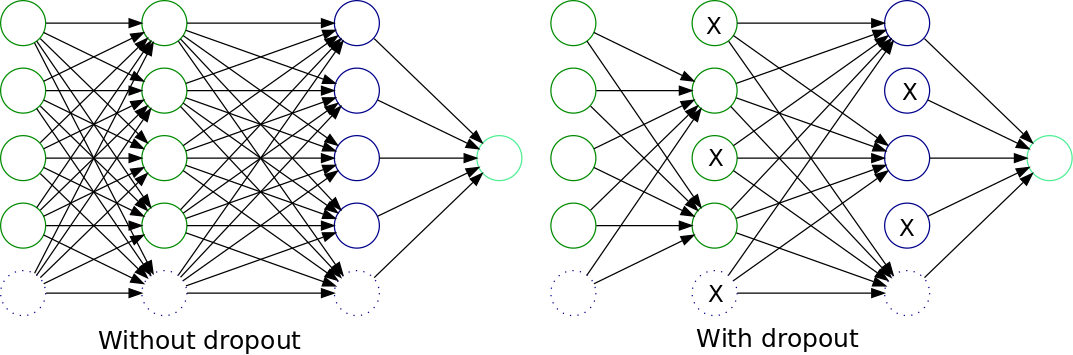


Begin calculating the class weights, hot-encoding the class labels and splitting the data into training and test.

In [0]:
sc = StandardScaler()
## calculate weights as the data is imbalanced
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train.ravel()), y_train.ravel())

def compile_samples(df):
    """ Compiles the dataframe into x,y and hot-encodes the labels"""
    df = df.dropna()
    # split into X,y,groups.
    X = df.drop(['operation_mode', 'Unnamed: 0', 'time'], axis=1).values
    Y = np.unique(df['operation_mode'].values, axis=1)
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(Y.ravel())
    encoded_Y = encoder.transform(Y.ravel())
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_Y)
    return X, dummy_y 

X, Y = compile_samples(df_quantiles)  

## standardize data for optimal performance
X = sc.fit_transform(X)

## split the data 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state= 0, shuffle=True)


The model itself can then be constructed and evaluated using 5-fold cross validation to calculate the training accuracy. 

Computing fold  1
Train acc: 0.854 Test acc: 0.8324 

Computing fold  2
Train acc: 0.8438 Test acc: 0.8567 

Computing fold  3
Train acc: 0.8493 Test acc: 0.8485 

Computing fold  4
Train acc: 0.8334 Test acc: 0.8898 

Computing fold  5
Train acc: 0.8562 Test acc: 0.8926 

Overall Training Accuracy: 86.400 (+/-) 4.710
F1: 86.4 +/- 2.355


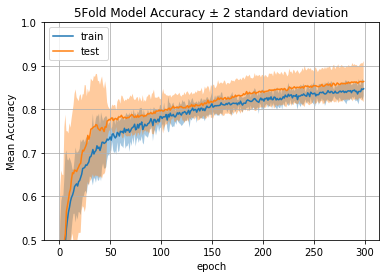

In [185]:
cv_train_hist = []
cv_test_hist = []
cv_conf_matrix = []
f1_scores = []

counter = 0

kf = KFold(n_splits=5, shuffle=False)
kf.get_n_splits(x_train, y_train)

for train_index, test_index in kf.split(x_train, y_train):
      counter += 1
      print("Computing fold ", counter) 
      
      #split the data into train/test for eval.
      X_tr, X_te = x_train[train_index], x_train[test_index]
      y_tr, y_te = y_train[train_index], y_train[test_index]
      X_tr = X_tr.astype(np.float) 
      X_te = X_te.astype(np.float) 
      
      ## create the neural network
      model = Sequential()
      model.add(Dense(15, input_dim=10, activation='relu'))
      model.add(Dropout(0.1))
      model.add(Dense(5, activation='softmax'))
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
      
      history = model.fit(X_tr, y_tr, epochs=300, batch_size=128, verbose=0,
                        validation_data= (X_te, y_te), class_weight= class_weights, 
                        shuffle= True)
      
      cv_train_hist.append(history.history['categorical_accuracy'])
      cv_test_hist.append(history.history['val_categorical_accuracy'])
      
      y_pred = model.predict(X_te, batch_size=4)

      # Compute normalised confusion matrix per fold
      cm = confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cv_conf_matrix.append(cm)

      # compute f1 scores  per fold
      f1_scores.append(f1_score(y_te.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))
      
      print("Train acc:", round(history.history['categorical_accuracy'][-1], 4), "Test acc:", round(history.history['val_categorical_accuracy'][-1], 4), "\n")

# Calculate overall training accuracy
cv_train_hist = np.array(cv_train_hist) #train
cv_test_hist = np.array(cv_test_hist) #test
print(f"Overall Training Accuracy: {np.mean(cv_test_hist[:,-1]) * 100 :.{3}f} (+/-) { 2 * np.std(cv_test_hist[:,-1]) * 100:.{3}f}")
print ('F1:', round(np.mean(f1_scores, axis=0) * 100, 3), '+/-', round(np.std(f1_scores, axis=0) * 100, 3))

# Plot model accuracy
def simple_errorplot(data):
    x = list(range(data.shape[1]))
    mean = np.mean(data, axis=0)
    y1 = mean + (2 * np.std(data, axis=0))
    y2 = mean - (2 * np.std(data, axis=0))
    plt.fill_between(x, y1, y2, alpha= 0.4)
    plt.plot(x, mean)


simple_errorplot(cv_train_hist)
simple_errorplot(cv_test_hist)
plt.title('5Fold Model Accuracy ± 2 standard deviation')
plt.ylabel('Mean Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0.5, 1)
plt.grid()
plt.show()


The training accuracy was further explored using a confusion matrix, plotted here as a heatmap. Similarly to the classification report used previously, this allows the performance of each class to be evaluated, highlighting where misclassification may be occuring.

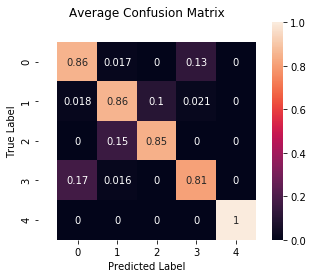

In [186]:
# Calculate + Plot the mean normalised confusion matrix
mean_conf = np.mean(cv_conf_matrix, axis=0)
sd_conf = np.std(cv_conf_matrix, axis=0)

fig = sns.heatmap(mean_conf, vmin=0, vmax=1, annot=True, square=True)
plt.xlim(-0.5, 5)
plt.ylim(5, -0.5)
plt.xlabel('Predicted Label')
plt.ylabel("True Label")
plt.title('Average Confusion Matrix')
plt.show()


The test / validation accuracy is reported below. This classifier also performs well

In [188]:
## Test accuracy
model = Sequential()
model.add(Dense(15, input_dim=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.fit(x_train, y_train, epochs=300, batch_size=128, verbose=0, 
          class_weight= class_weights, shuffle= True)

y_pred = model.predict(x_test, batch_size=4)

# Make the full classification report
class_labels = np.unique(y_test)
class_names = ['Correct Operation','Slow Grippers','High Velocity','High Force','Rotated Component']
print(classification_report(y_test, y_pred.round(), target_names=class_names))

print("Model Test Accuracy:", accuracy_score(y_test, y_pred.round()))

                   precision    recall  f1-score   support

Correct Operation       0.87      0.88      0.87       106
    Slow Grippers       0.93      0.86      0.89       114
    High Velocity       0.79      0.93      0.85        56
       High Force       0.90      0.84      0.87       108
Rotated Component       1.00      1.00      1.00        71

        micro avg       0.90      0.89      0.90       455
        macro avg       0.90      0.90      0.90       455
     weighted avg       0.90      0.89      0.90       455
      samples avg       0.89      0.89      0.89       455

Model Test Accuracy: 0.8901098901098901


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


**Findings:**
* Similarly to the random forest, a high accuracy was achieved - as demonstrated by the heatmap of confusion matrix and the model test accuracy.
* The classes perform consistently highly.
* The parameters of the network can be finely tuned, for example running for more epochs or experimenting with batch size - this may yeild a higher test accuracy. 




# **Part 2: Using real data**

*The data used above is simulated. In the real world failures are rare and it is often unclear under which circumstances they occur. How might this effect this method and how could this be solved?*



* **Unbalanced classes** can lead to poor models.
  * Overcome by **weighting** the classes, or doing some **augementation** / simulation of data as above.
  * Could also do some **up-/down-sampling** when defining training data 
* Real world data requires **cleaning**, and often takes more time to understand initially.
  * Greater **exploratory analysis** at the start could help to overcome some of this, and perhaps identify potential causes of failure.
  * Removing any obvious **outliers** / focusing on the 0.25, 0.5 and 0.75 quantiles would help to reduce some the noise in the data.
  * Cleaning may be necessary due to human error when assessing/recording the failure, the data may also be incomplete and need filtering.
* Unclear **causes of failure** may mean that initial models could just classify a failure or success (i.e. **binary classification**) and then failures could be analysed seperately, for example using a random forest to (hopefully) reveal significant parameters that may contribute to failed lines.